# **Digital Signal and Image Management - Assignement 1**<br/>

**Master's Degree in Data Science (A.Y. 2024/2025)**<br/>
**University of Milano - Bicocca**<br/>

Student: Sara **Nava**, mat. **870885**

## **Assignement Description**
Implement the **Zero-Crossing Rate** (ZCR) feature to describe a single-channel audio signal, starting from the commands shown during the laboratory.

Rules:

- Show the effects on classification performance for the dataset "free-spoken-digit-dataset" (recordings.tar).
- Verify the effect of using ZCR alone and in combination with other features available in the published notebook.
Using libraries such as Librosa is not allowed, as they offer pre-made functions to compute ZCR.
- It is, instead, possible to use numpy for the basic operations (shift, sign, etc.).
- Many variations of ZCR exist and will be accepted: whenever you make arbitrary decisions in the implementation, just describe them in the submission.

## **Import packages**
Import main packages

In [1]:
# Import
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
import tarfile
from shutil import copyfile

## **Load Data**
Data can be retrieved from Google Drive, as follows:

In [2]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/Digital Signal and Image Management/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Then, define the function `load_data` that allows to load data.

In [3]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

The function is structured as follows:
1. Load the data from disk
2. Extract the class specified in the filename
3. Split audio tracks into training set and test set
4. Normalize the data using training set statistics

## **Features**

The goal of this exercise is to define the **ZCR** function. According to the definition provided by [Wikipedia](https://en.wikipedia.org/wiki/Zero-crossing_rate), the *Zero Crossing Rate* is the **rate** at which a signal changes **from positive to negative or from negative to positive**. It can be represented by the following formula:
$ZCR = \frac{1}{T-1} \sum_{t=1}^{T-1} \mathbb{I}[s(t) \cdot s(t-1) < 0]$

In this view, the function must return a real value that represents the zero crossing rate. Let's make it step-by-step:

In [4]:
# Read file 0_jackson_0.wav
sound_rate, sound_data = wav.read('recordings/0_jackson_0.wav')

The array `sound_data` contains the audio sample, while `sound_rate` contains the sample rate (measured in samples per second, indicates how many samples can be played in one second).

In [5]:
print(sound_rate, sound_data)

8000 [-369 -431 -475 ...  301  324  304]


Now, compute the product of adjacent elements in the `sound_data` array and determine the sign of each product. Then, consider only the negative signs (because a negative sign indicates a change in sign between two adjacent elements), count them, and divide this total by the length of the array minus one.

In [6]:
signs = np.sign(np.multiply(sound_data[:-1], sound_data[1:], dtype=np.float64)) # signs of the product of adjacent numbers

# Now compute the ZCR as the number of cases of sign-switch
zcr_index = np.sum((signs<0) , keepdims=True) / (sound_data.shape[0]-1)
zcr_index

array([0.09617253])

This is the output that the function must produce for each audio track.

Now it is possible to develop the function to apply to the entire dataset.

In [7]:
def zcr(input):
  signs = np.sign(np.multiply(input[:-1], input[1:], dtype=np.float64)) # signs of the product of adjacent numbers

  # Now compute the ZCR as the rate of cases of sign-switch
  zcr_index = np.sum((signs<0) , keepdims=True) / (input.shape[0]-1)
  return zcr_index

### **Classification using only ZCR as feature**

Verify the effect of using **ZCR alone** on classification performance for the dataset "free-spoken-digit-dataset".

In [8]:
# Split data into training and test sets, applying normalization and using ZRC as feature extractor
x_train, x_test, y_train, y_test = load_data(feature_extractor=zcr, normalize = True)

Define SVM classificator with hyperparameters optimization:

In [9]:
# Define hyperparameters to try
p = {'C': [100, 500, 1000],
     'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   p,
                   cv = 2
                   )

Fit the model on training data and then test it:

In [10]:
clf = clf.fit(x_train, y_train)
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters combination:
 C: 100
 gamma: 1.0


Finally, make predictions on the test set and comment on the classification performance and confusion matrix.

In [11]:
# Make predictions
y_pred = clf.predict(x_test)

In [12]:
# Compute classificator performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.53      0.32        17
           1       0.12      0.50      0.19        10
           2       0.27      0.20      0.23        15
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        11
           5       0.12      0.14      0.13        14
           6       0.92      0.79      0.85        14
           7       0.00      0.00      0.00        19
           8       0.31      0.24      0.27        17
           9       0.00      0.00      0.00        14

    accuracy                           0.23       150
   macro avg       0.20      0.24      0.20       150
weighted avg       0.19      0.23      0.19       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Based on the retrieved results, starting with the **precision**, it is evident that—except for *class 6*—the rate of true positives among the predictions classified as true is quite low for each class. This indicates that the *classifier is not performing well in correctly identifying true* observations.

Similarly, the **recall** shows a comparable pattern: for most classes, a *very low percentage of actual positive instances were correctly classified*, with the exception of *class 6*, which has a higher recall, though *class 0* and *class 1* show slightly better results compared to the others, albeit still low overall. Notably, for classes 3, 4, 7, and 9, the recall is zero, indicating that no true positives were identified.

The **f1-score**, which combines both precision and recall, reflects these findings.

Finally, considering the macro and weighted averages for each metric (both around 20%) and the overall **accuracy** of **23%**, it is clear that the classifier is performing poorly on the audio signal classification task.

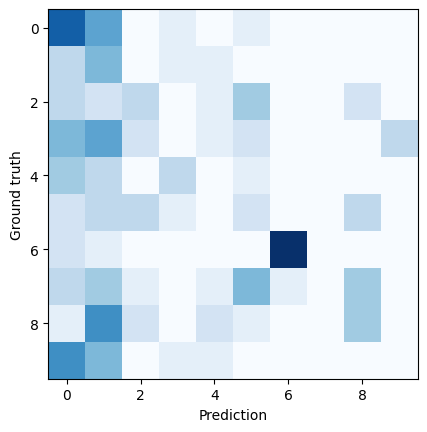

In [13]:
# Plot the confusion matrix
confusion_mat = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.imshow(confusion_mat, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

The **confusion matrix** summarizes the observed results well: the classifier performs particularly poorly in classifying classes 3, 4, 7, and 9, while showing some improvement in classes 0 and 1, and significantly better performance in class 6.

Overall, it is clear that the SVM is misclassifying a significant amount of data, as there is no prominent diagonal in the confusion matrix. An evident diagonal would indicate that a large proportion of data in each class is correctly classified. In this case, however, the classification appears almost random.

Additionally, it can be observed that no signals are assigned to *classes 7* and *9*.

### **Classification with features combination**

Verify the effect of using **ZCR in combination with features** `energy` and `duration` (defined subsequently) on classification performance for the dataset "free-spoken-digit-dataset".

Define `energy` function:

In [14]:
# Define energy function: sum of all squared elements in the audio track
def energy(array):
  return np.sum(np.square(array**1.0), keepdims=True)

Define `duration` function:

In [15]:
def duration(input):
  return np.array(input.shape)

Now, define a `combo_features` function, to combine `zcr` with `energy` and `duration` features.

In [16]:
def combo_features(input):
  return np.concatenate((zcr(input), energy(input), duration(input)))

At this point, repeat the same procedure as in the previous request: split data into training and test sets, and then train and test an SVM classifier with hyperparameter optimization on data.

In [17]:
# Split data into training and test sets, applying normalization and using ZRC as feature extractor
x_train2, x_test2, y_train2, y_test2 = load_data(feature_extractor=combo_features, normalize = True)

Define SVM classificator with hyperparameters optimization:

In [18]:
# Define hyperparameters to try
p = {'C': [100, 500, 1000],
     'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

clf_combo = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                         p,
                         cv = 2
                         )

Fit the model on training data and then test it:

In [19]:
clf_combo = clf_combo.fit(x_train2, y_train2)

# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf_combo.best_estimator_.C))
print(' gamma: '+str(clf_combo.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.5


Finally, make predictions on the test set and comment on the classification performance and confusion matrix.

In [20]:
# Make predictions
y_pred2 = clf_combo.predict(x_test2)

In [21]:
# Compute classificator performance
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        17
           1       0.37      0.70      0.48        10
           2       0.57      0.53      0.55        15
           3       0.73      0.42      0.53        19
           4       0.40      0.55      0.46        11
           5       0.41      0.50      0.45        14
           6       0.85      0.79      0.81        14
           7       0.42      0.26      0.32        19
           8       0.50      0.53      0.51        17
           9       0.67      0.71      0.69        14

    accuracy                           0.55       150
   macro avg       0.57      0.57      0.55       150
weighted avg       0.58      0.55      0.55       150



Compared to the previous classifier, applying SVM on data with a combination of features (ZCR, energy, and duration) results in **better performance**. Notably, the rate of true positives is no longer zero for any class. Once again, the classifier performs **best** on *class 6*, suggesting that this class is likely the most easily distinguishable, with well-defined characteristics that set it apart from the other classes.

In addition, *class 0* shows good performance in terms of both **precision** and **recall**, while *class 1* has relatively high recall but lower precision. This indicates that the classifier is good at identifying *class 1* signals but often misclassifies signals from other classes as belonging to *class 1*. Conversely, *class 3* exhibits the opposite behavior, with high precision but low recall, meaning the classifier is accurate when predicting *class 3*, but it fails to capture a large portion of the actual *class 3* signals.

Significantly, *class 9* —which was previously misclassified entirely when using only the ZCR feature— now shows a considerable improvement in both precision and recall. While some other classes still exhibit low performance, none have precision or recall values below about 30%, which demonstrates a clear improvement compared to the earlier results.

The aggregated metrics, such as **macro** and **weighted averages**, along with **accuracy**, are now around **55%**. While this is **still not highly satisfactory**, it represents a **marked improvement over the previous results**. Thus, the addition of energy and duration features has contributed to better overall classification performance.

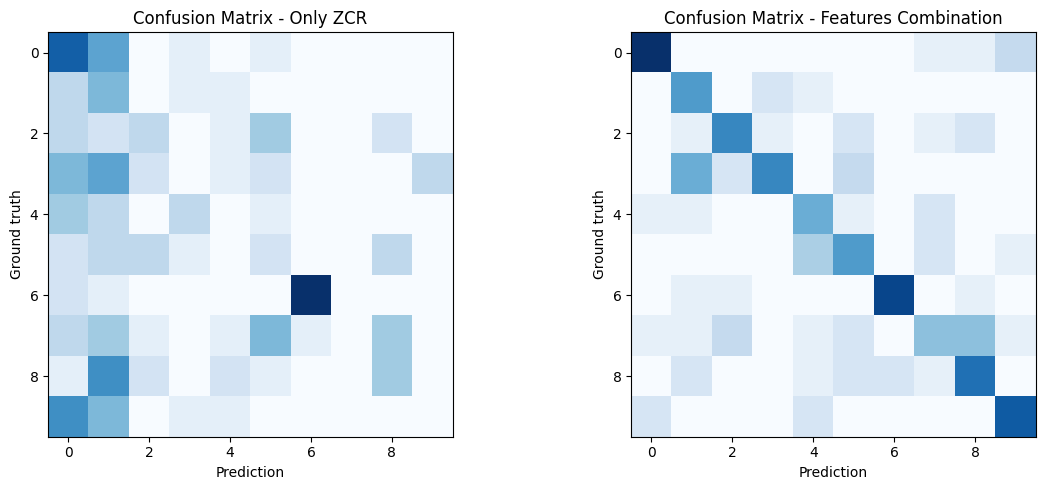

In [22]:
# Plot the confusion matrix and make comparison with previous results

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot the first confusion matrix
axes[0].imshow(confusion_mat, cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix - Only ZCR')
axes[0].set_xlabel('Prediction')
axes[0].set_ylabel('Ground truth')

# Plot the second confusion matrix
confusion_mat2 = confusion_matrix(y_pred=y_pred2, y_true=y_test2)
axes[1].imshow(confusion_mat2, cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix - Features Combination')
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Ground truth')

# Add some spacing between the subplots
plt.tight_layout()

# Show the plots
plt.show()

It is clear that the second confusion matrix shows a more pronounced diagonal,
indicating higher accuracy in classifying signals across all classes. The good
performance on *classes 6* and *0* is maintained, and there is a noticeable
improvement across the other classes. Moving away from the diagonal, the lighter-colored
squares represent a lower rate of misclassification, especially in comparison to the first
matrix, where the diagonal was not as evident.

In the second matrix, the majority of misclassifications occur in *class 3* (as previously
mentioned), where about half of its signals are incorrectly classified as *class 1*.
Additional misclassifications are observed in *class 5*, where some signals are assigned
to *class 4*, and in *class 7*, where there is some confusion with *class 8*.